#Check Hardware Info

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Dec 16 02:22:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


#Download Data (Run Only Once)

In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle

import os
os.environ['KAGGLE_USERNAME'] = "josephzheng1998"
os.environ['KAGGLE_KEY'] = "72fd2a56fcfde8d42fe037aa8d9be146"

!kaggle datasets download -d msambare/fer2013
!unzip -qq fer2013.zip
!rm fer2013.zip

     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=33a8c4501dba85947f7548a6b6d9bb9047a665315e77c8fc2e361a02b3c3b0d3
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
 76% 46.0M/60.3M [00:00<00:00, 207MB/s]
100% 60.3M/60.3M [00:00<00:00, 257MB/s]


In [4]:
!pip install split-folders

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import splitfolders
splitfolders.ratio('test', output='val_test', seed=1337, ratio=(0, 0.5, 0.5), group_prefix=None)

Copying files: 7178 files [00:01, 6112.94 files/s]


#Environment Setup

In [29]:
import os
import numpy as np
from PIL import Image

import torch
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score
from IPython.display import Image
from IPython.core.display import Image, display
from torchvision.utils import save_image
import time
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [16]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
print(device)

cuda


#Data Preprocessing

In [17]:
batch_size = 64
train_transform = transforms.Compose([
                                      transforms.RandomRotation(45),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_dataset = ImageFolder(root='train/', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)

dev_dataset = ImageFolder(root='val_test/val/', transform=val_transform)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

test_dataset = ImageFolder(root='val_test/test/', transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

print('train dataset: {} images {} classes'.format(len(train_dataset), len(train_dataset.classes)))
print('dev dataset: {} images {} classes'.format(len(dev_dataset), len(dev_dataset.classes)))
print('test dataset: {} images {} classes'.format(len(test_dataset), len(test_dataset.classes)))

train dataset: 28709 images 7 classes
dev dataset: 3587 images 7 classes
test dataset: 3591 images 7 classes


#Plot Functions

In [18]:
def make_plots(a, b, model_name, plot_type):
    plt.figure(1)
    plt.plot(range(1, len(a) + 1), a, 'b', label='train')
    plt.plot(range(1, len(b) + 1), b, 'g', label='valid')
    plt.title('{} Train/Valid {}'.format(model_name, plot_type))
    plt.xlabel('Epochs')
    plt.ylabel(plot_type)
    plt.legend()
    plt.savefig('/content/gdrive/My Drive/{}_{}.png'.format(model_name, '_'.join(plot_type.lower().split())))
    plt.show()

In [19]:
def plot_matrix(matrix, dataset, model_name):
    emotion_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    matrix_df = pd.DataFrame(matrix, index=emotion_list, columns=emotion_list)
    plt.figure(figsize=(12,8))
    ax = sns.heatmap(matrix_df, cmap='YlGnBu', annot=True, fmt='d', annot_kws={'size': 16}).set_title('{} Confusion Matrix ({})'.format(model_name, dataset))
    plt.savefig('/content/gdrive/My Drive/{}_{}_matrix.png'.format('_'.join(model_name.split()), dataset.lower()))
    plt.show()

In [ ]:
def compare(x):
    features, idx_list = model.encoder(x)
    recon_x = model.decoder(features, idx_list)
    return torch.cat([x, recon_x])

#Multitasking Model

In [9]:
class EncoderBlock(nn.Module):
  def __init__(self, input_chan, output_chan):
    super(EncoderBlock, self).__init__()
    self.Conv1 = nn.Conv2d(in_channels=input_chan, out_channels=output_chan, kernel_size=(3,3),stride=(1,1), padding=(1,1))
    self.norm1 = nn.BatchNorm2d(output_chan)
    self.act1 = nn.ReLU()
    self.Conv2 = nn.Conv2d(in_channels=output_chan, out_channels=output_chan, kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.norm2 = nn.BatchNorm2d(output_chan)
    self.act2 = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), return_indices=True)
  def forward(self,x):
    x=self.Conv1(x)
    x=self.norm1(x)
    x=self.act1(x)
    x=self.Conv2(x)
    x=self.norm2(x)
    x=self.act2(x)
    x,indices = self.pool(x)
    return (x, indices)



class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.encoderLayer1 = EncoderBlock(3,32)
    self.encoderLayer2 = EncoderBlock(32,64)
    self.encoderLayer3 = EncoderBlock(64,128)
    self.encoderLayer4 = EncoderBlock(128,256)
    self.encoderLin = nn.Sequential(
        nn.Flatten(),
        #change output to 686
        nn.Linear(256*3*3, 686)
    )
  def forward(self,x):
    indicesList = []
    x,indices1 = self.encoderLayer1(x)
    indicesList.append(indices1)
    x,indices2 = self.encoderLayer2(x)
    indicesList.append(indices2)
    x,indices3 = self.encoderLayer3(x)
    indicesList.append(indices3)
    x,indices4 = self.encoderLayer4(x)
    indicesList.append(indices4)
    x=self.encoderLin(x)
    return x, indicesList

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.TConv1 = nn.ConvTranspose2d(in_channels=256, out_channels=256,kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.norm1 = nn.BatchNorm2d(256)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxUnpool2d(kernel_size=(2,2),stride=(2,2))
    self.TConv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.norm2 = nn.BatchNorm2d(128)
    self.act2 = nn.ReLU()
          
    self.pool2 = nn.MaxUnpool2d(kernel_size=(2,2),stride=(2,2))
    self.TConv3 = nn.ConvTranspose2d(in_channels=128, out_channels=128,kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.norm3 = nn.BatchNorm2d(128)
    self.act3 = nn.ReLU()
    self.TConv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64,kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.norm4 = nn.BatchNorm2d(64)
    self.act4 = nn.ReLU()
           
    self.pool3 = nn.MaxUnpool2d(kernel_size=(2,2),stride=(2,2))
    self.TConv5 = nn.ConvTranspose2d(in_channels=64, out_channels=64,kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.norm5 = nn.BatchNorm2d(64)
    self.act5 = nn.ReLU()
    self.TConv6 = nn.ConvTranspose2d(in_channels=64, out_channels=32,kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.norm6 = nn.BatchNorm2d(32)
    self.act6 = nn.ReLU()
          
    self.pool4 = nn.MaxUnpool2d(kernel_size=(2,2),stride=(2,2))
    self.TConv7 = nn.ConvTranspose2d(in_channels=32, out_channels=32,kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.norm7 = nn.BatchNorm2d(32)
    self.act7 = nn.ReLU()
    self.TConv8 = nn.ConvTranspose2d(in_channels=32, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.decoderLin = nn.Sequential(
        #change input to 686
        nn.Linear(686, 256*3*3)
    )
  def forward(self,x,indicesList):
    x=self.decoderLin(x)
    x=x.view(-1,256,3,3)
    x=self.TConv1(x)
    x=self.norm1(x)
    x=self.act1(x)
    x=self.pool1(x, indicesList[3])
    x=self.TConv2(x)
    x=self.norm2(x)
    x=self.act2(x)

    x=self.pool2(x, indicesList[2])
    x=self.TConv3(x)
    x=self.norm3(x)
    x=self.act3(x)
    x=self.TConv4(x)
    x=self.norm4(x)
    x=self.act4(x)

    x=self.pool3(x, indicesList[1])
    x=self.TConv5(x)
    x=self.norm5(x)
    x=self.act5(x)
    x=self.TConv6(x)
    x=self.norm6(x)
    x=self.act6(x)

    x=self.pool4(x, indicesList[0])
    x=self.TConv7(x)
    x=self.norm7(x)
    x=self.act7(x)
    x=self.TConv8(x)
    return x

class LinClassifier(nn.Module):
  def __init__(self):
    super(LinClassifier, self).__init__()
    self.layers = nn.Sequential(
        nn.ReLU(),
        #change input to 686
        nn.Linear(686,512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512,7)
    )
  def forward(self, x):
    return self.layers(x) 


class AutoClassifier(nn.Module):
  def __init__(self):
    super(AutoClassifier, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.classifier = LinClassifier()
  def forwardAuto(self,x):
    x,indicesList=self.encoder(x)
    reconstructed=self.classifier(x, indicesList)
    return x
  def forwardClassify(self,x):
    x,indicesList = self.encoder(x)
    output = self.classifier(x)
    return x



In [37]:
# train the multitasking model
def train(model, train_loader, val_loader, recon_criterion, class_criterion, optimizer, scheduler, epochs, device):
    t_start = time.time()
    train_recon_losses = []
    train_class_losses = []
    train_accs = []
    val_class_losses = []
    val_recon_losses = []
    val_accs = []
    for epoch in range(epochs):
        model.train()
        running_recon_loss = 0
        running_class_loss = 0
        total = 0
        correct = 0
        for idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            features, idx_list = model.encoder.forward(images)
            output = model.classifier.forward(features)
            recon_images = model.decoder.forward(features, idx_list)
            class_loss = class_criterion(output, labels)
            recon_loss = recon_criterion(recon_images, images)
            total_loss = class_loss + 10*recon_loss 
            total_loss.backward()
            #class_loss.backward()
            optimizer.step()
            preds = torch.argmax(output, dim=1)
            correct += (preds == labels).sum().item()
            running_recon_loss += float(recon_loss.item() * images.shape[0])
            running_class_loss += float(class_loss.item() * images.shape[0])
            total += images.shape[0]
            #recon_loss = 0
            del images
            del labels
            del recon_images
            del features
            del idx_list
            del output
            del recon_loss
            del class_loss
            del preds
            del total_loss
            torch.cuda.empty_cache()
        val_class_loss, val_recon_loss, val_acc = validate(model, val_loader, recon_criterion, class_criterion, device)
        val_total_loss = val_recon_loss + val_class_loss
        train_recon_loss = running_recon_loss/total
        train_class_loss = running_class_loss/total
        train_total_loss = train_recon_loss + train_class_loss
        train_acc = correct/total 
        train_recon_losses.append(train_recon_loss)
        train_class_losses.append(train_class_loss)
        train_accs.append(train_acc)
        val_class_losses.append(val_class_loss)
        val_recon_losses.append(val_recon_loss)
        val_accs.append(val_acc)
        scheduler.step(val_class_loss)
        to_print = "Epoch: {}/{}, Training Time:{:.2f}, Trained Samples: {}/{}, Train Total Loss: {:.5f}, Train Recon Loss: {:.5f}, Train Class Loss: {:.5f} Train Accuracy: {:.5f}, Val Total Loss: {:.5f}, Val Recon Loss: {:.5f}, Val Class Loss: {:.5f}, Val Accuracy: {:.5f}".format(
                epoch+1, epochs, time.time()-t_start, total, len(train_loader.dataset), train_total_loss, train_recon_loss, train_class_loss, train_acc,
                    val_total_loss, val_recon_loss, val_class_loss, val_acc)
        print(to_print)
        if (epoch+1) % 10 == 0:
            saved_model = {
                        'train_epochs': epoch + 1,
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'recon_criterion': recon_criterion.state_dict(),
                        'class_criterion': class_criterion.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        'train_class_losses': train_class_losses,
                        'train_recon_losses': train_recon_losses,
                        'train_accuracy': train_accs,
                        'valid_class_losses': val_class_losses,
                        'valid_accuracy': val_accs,
                        'val_recon_losses': val_recon_losses,
                        }
            torch.save(saved_model, 'gdrive/MyDrive/complete_model{}'.format(epoch+1))
    return train_recon_losses, train_class_losses, train_accs, val_class_losses, val_recon_losses, val_accs

# validate the multitasking model
def validate(model, val_loader, recon_criterion, class_criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_recon_loss = 0
    running_class_loss = 0
    
    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            features, idx_list = model.encoder.forward(images)
            output = model.classifier.forward(features)
            recon_images = model.decoder.forward(features, idx_list)
            class_loss = class_criterion(output, labels)
            recon_loss = recon_criterion(recon_images, images)
            running_recon_loss += float(recon_loss.item() * labels.shape[0])
            running_class_loss += float(class_loss * labels.shape[0])
            total += labels.shape[0]
            preds = torch.argmax(output, dim=1)
            correct += (preds == labels).sum().item()
            """
            print(correct)
            print(preds)
            print(labels)
            """
            del images
            del labels
            del recon_images
            del features
            del idx_list
            del output
            del recon_loss
            del class_loss
            del preds
            torch.cuda.empty_cache()
    return running_class_loss/total, running_recon_loss/total, correct/total


# only train the autoencoder part of the model
def pretrain(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device):
    t_start = time.time()
    train_recon_losses = []
    val_recon_losses = []
    for epoch in range(epochs):
        model.train()
        running_recon_loss = 0
        total = 0
        for idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            features, idx_list = model.encoder.forward(images)
            recon_images = model.decoder.forward(features, idx_list)
            recon_loss = criterion(recon_images, images)
            recon_loss.backward()
            optimizer.step()
            running_recon_loss += float(recon_loss.item() * images.shape[0])
            total += images.shape[0]
            del images
            del labels
            del recon_images
            del features
            del idx_list
            del recon_loss
            torch.cuda.empty_cache()
        val_recon_loss = pre_validate(model, val_loader, criterion, device)
        train_recon_loss = running_recon_loss/total 
        train_recon_losses.append(train_recon_loss)
        val_recon_losses.append(val_recon_loss)
        scheduler.step(val_recon_loss)
        to_print = "Epoch: {}/{}, Training Time:{:.2f}, Trained Samples: {}/{}, Train Recon Loss: {:.5f}, Val Recon Loss: {:.5f}".format(
                epoch+1, epochs, time.time()-t_start, total, len(train_loader.dataset), train_recon_loss,
                     val_recon_loss)
        print(to_print)
        if epoch % 10 == 0:
            saved_model = {
                        'train_epochs': epoch + 1,
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'recon_criterion': criterion.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        }
            torch.save(saved_model, 'gdrive/MyDrive/pre_model{}'.format(epoch))
    return train_recon_losses, val_recon_losses 

# only validate the autoencoder part of the model
def pre_validate(model, val_loader, recon_criterion, device):
    model.eval()
    total = 0
    running_recon_loss = 0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            features, idx_list = model.encoder.forward(images)
            recon_images = model.decoder.forward(features, idx_list)
            recon_loss = recon_criterion(recon_images, images)
            running_recon_loss += float(recon_loss.item() * labels.shape[0])
            total += images.shape[0]
            del images
            del labels
            del recon_images
            del features
            del idx_list
            del recon_loss
            torch.cuda.empty_cache()
    return running_recon_loss/total

# only train the model's classifier
def train_class(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device):
    t_start = time.time()
    train_class_losses = []
    train_accs = []
    val_class_losses = []
    val_accs = []
    for epoch in range(epochs):
        model.train()
        running_class_loss = 0
        total = 0
        correct = 0
        for idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            features, idx_list = model.encoder.forward(images)
            features = features.detach()
            output = model.classifier.forward(features)
            class_loss = criterion(output, labels)
            class_loss.backward()
            optimizer.step()
            preds = torch.argmax(output, dim=1)
            correct += (preds == labels).sum().item()
            running_class_loss += float(class_loss.item() * images.shape[0])
            total += images.shape[0]
            del images
            del labels
            del features
            del idx_list
            del output
            del class_loss
            del preds
            torch.cuda.empty_cache()
        val_class_loss, val_acc = validate_class(model, val_loader, criterion, device)
        train_class_loss = running_class_loss/total
        train_acc = correct/total 
        train_class_losses.append(train_class_loss)
        train_accs.append(train_acc)
        val_class_losses.append(val_class_loss)
        val_accs.append(val_acc)
        scheduler.step(val_class_loss)
        to_print = "Epoch: {}/{}, Training Time:{:.2f}, Trained Samples: {}/{}, Train Class Loss: {:.5f} Train Accuracy: {:.5f}, Val Class Loss: {:.5f}, Val Accuracy: {:.5f}".format(
                epoch+1, epochs, time.time()-t_start, total, len(train_loader.dataset), train_class_loss, train_acc,
                     val_class_loss, val_acc)
        print(to_print)
        if (epoch+1) % 10 == 0:
            saved_model = {
                        'train_epochs': epoch + 1,
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'criterion': criterion.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        'train_class_losses': train_class_losses,
                        'train_accuracy': train_accs,
                        'valid_class_losses': val_class_losses,
                        'valid_accuracy': val_accs,
                        }
            torch.save(saved_model, 'gdrive/MyDrive/complete_model{}'.format(epoch+1))
    return train_class_losses, train_accs, val_class_losses, val_accs

# only validate the model's classifier
def validate_class(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_class_loss = 0
    
    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            features, idx_list = model.encoder.forward(images)
            features = features.detach()
            output = model.classifier.forward(features)
            class_loss = class_criterion(output, labels)
            running_class_loss += float(class_loss * labels.shape[0])
            total += labels.shape[0]
            preds = torch.argmax(output, dim=1)
            correct += (preds == labels).sum().item()
            """
            print(correct)
            print(preds)
            print(labels)
            """
            del images
            del labels
            del features
            del idx_list
            del output
            del class_loss
            del preds
            torch.cuda.empty_cache()
    return running_class_loss/total, correct/total

# Training and Validating Function

In [ ]:
# train the multitasking model
def train(model, train_loader, val_loader, recon_criterion, class_criterion, optimizer, scheduler, epochs, device):
    t_start = time.time()
    train_recon_losses = []
    train_class_losses = []
    train_accs = []
    val_class_losses = []
    val_recon_losses = []
    val_accs = []
    for epoch in range(epochs):
        model.train()
        running_recon_loss = 0
        running_class_loss = 0
        total = 0
        correct = 0
        for idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            features, idx_list = model.encoder.forward(images)
            output = model.classifier.forward(features)
            recon_images = model.decoder.forward(features, idx_list)
            class_loss = class_criterion(output, labels)
            recon_loss = recon_criterion(recon_images, images)
            total_loss = class_loss + 10*recon_loss 
            total_loss.backward()
            #class_loss.backward()
            optimizer.step()
            preds = torch.argmax(output, dim=1)
            correct += (preds == labels).sum().item()
            running_recon_loss += float(recon_loss.item() * images.shape[0])
            running_class_loss += float(class_loss.item() * images.shape[0])
            total += images.shape[0]
            #recon_loss = 0
            del images
            del labels
            del recon_images
            del features
            del idx_list
            del output
            del recon_loss
            del class_loss
            del preds
            del total_loss
            torch.cuda.empty_cache()
        val_class_loss, val_recon_loss, val_acc = validate(model, val_loader, recon_criterion, class_criterion, device)
        val_total_loss = val_recon_loss + val_class_loss
        train_recon_loss = running_recon_loss/total
        train_class_loss = running_class_loss/total
        train_total_loss = train_recon_loss + train_class_loss
        train_acc = correct/total 
        train_recon_losses.append(train_recon_loss)
        train_class_losses.append(train_class_loss)
        train_accs.append(train_acc)
        val_class_losses.append(val_class_loss)
        val_recon_losses.append(val_recon_loss)
        val_accs.append(val_acc)
        scheduler.step(val_class_loss)
        to_print = "Epoch: {}/{}, Training Time:{:.2f}, Trained Samples: {}/{}, Train Total Loss: {:.5f}, Train Recon Loss: {:.5f}, Train Class Loss: {:.5f} Train Accuracy: {:.5f}, Val Total Loss: {:.5f}, Val Recon Loss: {:.5f}, Val Class Loss: {:.5f}, Val Accuracy: {:.5f}".format(
                epoch+1, epochs, time.time()-t_start, total, len(train_loader.dataset), train_total_loss, train_recon_loss, train_class_loss, train_acc,
                    val_total_loss, val_recon_loss, val_class_loss, val_acc)
        print(to_print)
        if (epoch+1) % 10 == 0:
            saved_model = {
                        'train_epochs': epoch + 1,
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'recon_criterion': recon_criterion.state_dict(),
                        'class_criterion': class_criterion.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        'train_class_losses': train_class_losses,
                        'train_recon_losses': train_recon_losses,
                        'train_accuracy': train_accs,
                        'valid_class_losses': val_class_losses,
                        'valid_accuracy': val_accs,
                        'val_recon_losses': val_recon_losses,
                        }
            torch.save(saved_model, 'gdrive/MyDrive/complete_model{}'.format(epoch+1))
    return train_recon_losses, train_class_losses, train_accs, val_class_losses, val_recon_losses, val_accs

# validate the multitasking model
def validate(model, val_loader, recon_criterion, class_criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_recon_loss = 0
    running_class_loss = 0
    
    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            features, idx_list = model.encoder.forward(images)
            output = model.classifier.forward(features)
            recon_images = model.decoder.forward(features, idx_list)
            class_loss = class_criterion(output, labels)
            recon_loss = recon_criterion(recon_images, images)
            running_recon_loss += float(recon_loss.item() * labels.shape[0])
            running_class_loss += float(class_loss * labels.shape[0])
            total += labels.shape[0]
            preds = torch.argmax(output, dim=1)
            correct += (preds == labels).sum().item()
            """
            print(correct)
            print(preds)
            print(labels)
            """
            del images
            del labels
            del recon_images
            del features
            del idx_list
            del output
            del recon_loss
            del class_loss
            del preds
            torch.cuda.empty_cache()
    return running_class_loss/total, running_recon_loss/total, correct/total




In [ ]:
# only train the autoencoder part of the model
def pretrain(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device):
    t_start = time.time()
    train_recon_losses = []
    val_recon_losses = []
    for epoch in range(epochs):
        model.train()
        running_recon_loss = 0
        total = 0
        for idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            features, idx_list = model.encoder.forward(images)
            recon_images = model.decoder.forward(features, idx_list)
            recon_loss = criterion(recon_images, images)
            recon_loss.backward()
            optimizer.step()
            running_recon_loss += float(recon_loss.item() * images.shape[0])
            total += images.shape[0]
            del images
            del labels
            del recon_images
            del features
            del idx_list
            del recon_loss
            torch.cuda.empty_cache()
        val_recon_loss = pre_validate(model, val_loader, criterion, device)
        train_recon_loss = running_recon_loss/total 
        train_recon_losses.append(train_recon_loss)
        val_recon_losses.append(val_recon_loss)
        scheduler.step(val_recon_loss)
        to_print = "Epoch: {}/{}, Training Time:{:.2f}, Trained Samples: {}/{}, Train Recon Loss: {:.5f}, Val Recon Loss: {:.5f}".format(
                epoch+1, epochs, time.time()-t_start, total, len(train_loader.dataset), train_recon_loss,
                     val_recon_loss)
        print(to_print)
        if epoch % 10 == 0:
            saved_model = {
                        'train_epochs': epoch + 1,
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'recon_criterion': criterion.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        }
            torch.save(saved_model, 'gdrive/MyDrive/pre_model{}'.format(epoch))
    return train_recon_losses, val_recon_losses 

# only validate the autoencoder part of the model
def pre_validate(model, val_loader, recon_criterion, device):
    model.eval()
    total = 0
    running_recon_loss = 0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            features, idx_list = model.encoder.forward(images)
            recon_images = model.decoder.forward(features, idx_list)
            recon_loss = recon_criterion(recon_images, images)
            running_recon_loss += float(recon_loss.item() * labels.shape[0])
            total += images.shape[0]
            del images
            del labels
            del recon_images
            del features
            del idx_list
            del recon_loss
            torch.cuda.empty_cache()
    return running_recon_loss/total



In [ ]:
# only train the model's classifier
def train_class(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device):
    t_start = time.time()
    train_class_losses = []
    train_accs = []
    val_class_losses = []
    val_accs = []
    for epoch in range(epochs):
        model.train()
        running_class_loss = 0
        total = 0
        correct = 0
        for idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            features, idx_list = model.encoder.forward(images)
            features = features.detach()
            output = model.classifier.forward(features)
            class_loss = criterion(output, labels)
            class_loss.backward()
            optimizer.step()
            preds = torch.argmax(output, dim=1)
            correct += (preds == labels).sum().item()
            running_class_loss += float(class_loss.item() * images.shape[0])
            total += images.shape[0]
            del images
            del labels
            del features
            del idx_list
            del output
            del class_loss
            del preds
            torch.cuda.empty_cache()
        val_class_loss, val_acc = validate_class(model, val_loader, criterion, device)
        train_class_loss = running_class_loss/total
        train_acc = correct/total 
        train_class_losses.append(train_class_loss)
        train_accs.append(train_acc)
        val_class_losses.append(val_class_loss)
        val_accs.append(val_acc)
        scheduler.step(val_class_loss)
        to_print = "Epoch: {}/{}, Training Time:{:.2f}, Trained Samples: {}/{}, Train Class Loss: {:.5f} Train Accuracy: {:.5f}, Val Class Loss: {:.5f}, Val Accuracy: {:.5f}".format(
                epoch+1, epochs, time.time()-t_start, total, len(train_loader.dataset), train_class_loss, train_acc,
                     val_class_loss, val_acc)
        print(to_print)
        if (epoch+1) % 10 == 0:
            saved_model = {
                        'train_epochs': epoch + 1,
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'criterion': criterion.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        'train_class_losses': train_class_losses,
                        'train_accuracy': train_accs,
                        'valid_class_losses': val_class_losses,
                        'valid_accuracy': val_accs,
                        }
            torch.save(saved_model, 'gdrive/MyDrive/complete_model{}'.format(epoch+1))
    return train_class_losses, train_accs, val_class_losses, val_accs

# only validate the model's classifier
def validate_class(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_class_loss = 0
    
    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            features, idx_list = model.encoder.forward(images)
            features = features.detach()
            output = model.classifier.forward(features)
            class_loss = class_criterion(output, labels)
            running_class_loss += float(class_loss * labels.shape[0])
            total += labels.shape[0]
            preds = torch.argmax(output, dim=1)
            correct += (preds == labels).sum().item()
            """
            print(correct)
            print(preds)
            print(labels)
            """
            del images
            del labels
            del features
            del idx_list
            del output
            del class_loss
            del preds
            torch.cuda.empty_cache()
    return running_class_loss/total, correct/total

# Dimensionality Reduction 

In [11]:
model = AutoClassifier()
model.to(device)

AutoClassifier(
  (encoder): Encoder(
    (encoderLayer1): EncoderBlock(
      (Conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (Conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (encoderLayer2): EncoderBlock(
      (Conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (Conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()


In [12]:
criterion = nn.MSELoss()
epochs = 80
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, patience=2, verbose=True)

In [20]:
# train the encoder and decoder
pre_train_loss, pre_val_loss = pretrain(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs, device)

Epoch: 1/80, Training Time:28.36, Trained Samples: 28709/28709, Train Recon Loss: 0.84157, Val Recon Loss: 0.21435
Epoch: 2/80, Training Time:59.12, Trained Samples: 28709/28709, Train Recon Loss: 0.19319, Val Recon Loss: 0.14209
Epoch: 3/80, Training Time:87.07, Trained Samples: 28709/28709, Train Recon Loss: 0.14194, Val Recon Loss: 0.12963
Epoch: 4/80, Training Time:115.10, Trained Samples: 28709/28709, Train Recon Loss: 0.11730, Val Recon Loss: 0.08492
Epoch: 5/80, Training Time:142.90, Trained Samples: 28709/28709, Train Recon Loss: 0.10268, Val Recon Loss: 0.08074
Epoch: 6/80, Training Time:170.62, Trained Samples: 28709/28709, Train Recon Loss: 0.09202, Val Recon Loss: 0.09384
Epoch: 7/80, Training Time:198.51, Trained Samples: 28709/28709, Train Recon Loss: 0.08590, Val Recon Loss: 0.06385
Epoch: 8/80, Training Time:226.19, Trained Samples: 28709/28709, Train Recon Loss: 0.08277, Val Recon Loss: 0.06154
Epoch: 9/80, Training Time:253.81, Trained Samples: 28709/28709, Train Reco

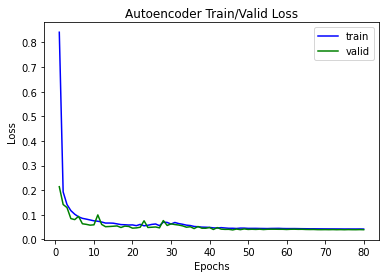

In [22]:
make_plots(pre_train_loss, pre_val_loss, "Autoencoder", "Loss")

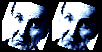

In [36]:
#compare the reconstructed image with the original image
fixed_x = train_dataset[random.randint(1,100)][0].unsqueeze(0).to(device)
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

In [39]:
class_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, patience=2, verbose=True)
epoch = 80

In [40]:
train_class_losses, train_accs, val_class_losses, val_accs = train_class(model, train_loader, dev_loader, class_criterion, optimizer, scheduler, epochs, device)

Epoch: 1/80, Training Time:20.68, Trained Samples: 28709/28709, Train Class Loss: 4.54429 Train Accuracy: 0.24494, Val Class Loss: 1.87519, Val Accuracy: 0.24700
Epoch: 2/80, Training Time:41.01, Trained Samples: 28709/28709, Train Class Loss: 1.85516 Train Accuracy: 0.25131, Val Class Loss: 1.84374, Val Accuracy: 0.24728


KeyboardInterrupt: ignored

In [ ]:
make_plots(train_accs, val_accs, "Classifier", "Accuracy")

# Train and Test the Multitasking Model

In [ ]:
model = AutoClassifier()
model.to(device)

AutoClassifier(
  (encoder): Encoder(
    (encoderLayer1): EncoderBlock(
      (Conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (Conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (encoderLayer2): EncoderBlock(
      (Conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (Conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()


In [ ]:
recon_criterion = nn.MSELoss()
class_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, patience=2, verbose=True)
epochs = 100

In [ ]:
train_recon_losses, train_class_losses, train_accs, val_class_losses, val_recon_losses, val_accs = train(model, train_loader, dev_loader, recon_criterion, class_criterion, optimizer, scheduler, epochs, device)

Epoch: 1/100, Training Time:22.08, Trained Samples: 28709/28709, Train Total Loss: 2.00723, Train Recon Loss: 0.19358, Train Class Loss: 1.81365 Train Accuracy: 0.24289, Val Total Loss: 1.86848, Val Recon Loss: 0.09256, Val Class Loss: 1.77592, Val Accuracy: 0.24868
Epoch: 2/100, Training Time:44.35, Trained Samples: 28709/28709, Train Total Loss: 1.79219, Train Recon Loss: 0.10203, Train Class Loss: 1.69017 Train Accuracy: 0.31760, Val Total Loss: 1.66965, Val Recon Loss: 0.11322, Val Class Loss: 1.55643, Val Accuracy: 0.38528
Epoch: 3/100, Training Time:66.73, Trained Samples: 28709/28709, Train Total Loss: 1.60358, Train Recon Loss: 0.09055, Train Class Loss: 1.51303 Train Accuracy: 0.40782, Val Total Loss: 1.52458, Val Recon Loss: 0.11369, Val Class Loss: 1.41089, Val Accuracy: 0.45163
Epoch: 4/100, Training Time:88.70, Trained Samples: 28709/28709, Train Total Loss: 1.46478, Train Recon Loss: 0.08229, Train Class Loss: 1.38249 Train Accuracy: 0.46233, Val Total Loss: 1.34615, Val 

In [ ]:
_, _, test_acc = validate(model, test_loader, recon_criterion, class_criterion, device)